In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
df = pd.read_csv('../data/raw-polls-updated.csv')


# These are still used for a handful of plots
polls = pd.read_csv('../data/raw-polls.csv') 
pollster_ratings = pd.read_csv('../data/pollster-ratings.csv')

First let's take a look at various relevant correlations between our predictors and possible response variables

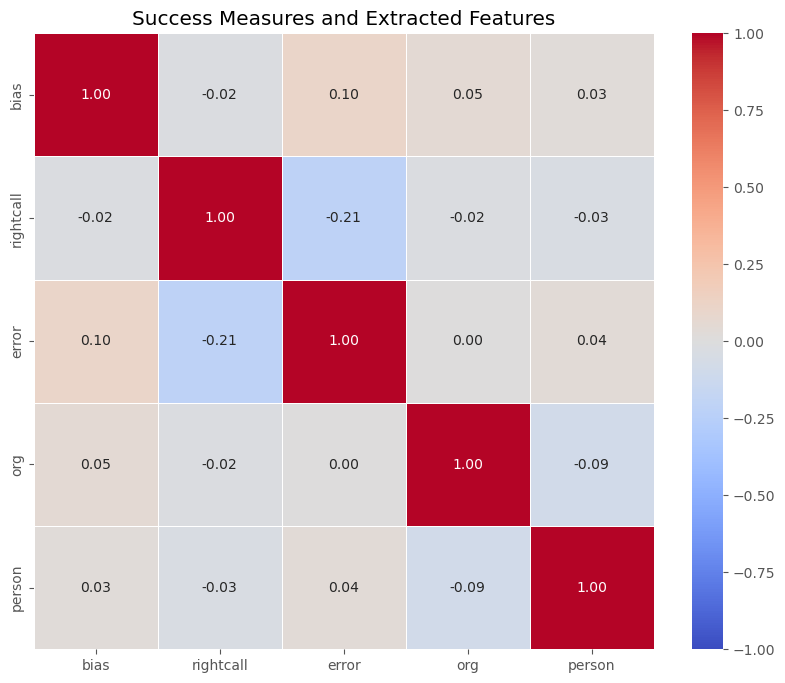

In [3]:
# Heat map exploring if being a ORG v Person is correlated with features like "rightcall" or "bias" - no strong correlations here 
heatmap_data = df[['bias', 'rightcall', 'error', 'org', 'person']]
correlation_matrix = heatmap_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, 
            cmap='coolwarm', fmt='.2f', 
            linewidths=.5, vmax = 1, vmin = -1)
plt.title('Success Measures and Extracted Features');

Clearly, we're going to run into some issues with our final modelling. Organization and person having no correlation with any of our response variables options is a good sign for polls being accurate but unideal for our hope of modelling polling accuracy. Most interestingly, all three of our response options are near-completely uncorrelated. Error and bias should have little to no linear correlation (absolute value is a non-linear transformation) but intuitively we would expect error to be correlated with right call. Logically, a poll with higher error should be less likely to make the right call. No correlation here could suggest that polls that are right still have quite a lot of error. That is, even though they make the right call on who wins the race, polls still overestimate the margin of victory by enough that these variables show a nearly no correlation.

Let's take a look at our methodologies and search for correlations there.

In [4]:
df[['Live Phone', 'Online', 'IVR', 'Text', 'Face-to-Face', 'Mail']].sum()

Live Phone      5861
Online          2376
IVR             3352
Text             275
Face-to-Face       0
Mail              22
dtype: int64

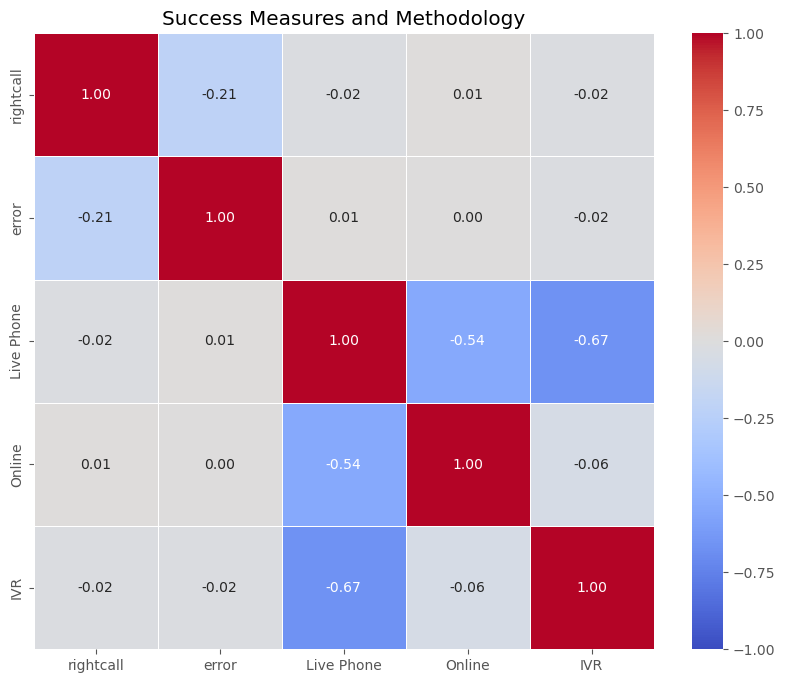

In [5]:
heatmap_data = df[['rightcall', 'error', 'Live Phone', 'Online', 'IVR']]
correlation_matrix = heatmap_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, 
            cmap='coolwarm', fmt='.2f', 
            linewidths=.5, vmax = 1, vmin = -1)
plt.title('Success Measures and Methodology');

Looking instead at our most common methodologies we see some correlations between them which we expect because we know from our feature extraction stage that polls could use multiple methodologies. Unfortunately, we see no correlation between either and our success metrics so this is seeming like a dead end and a moderate worry for our future modelling.

Let's pivot and take a more circumspect approach to our exploration.

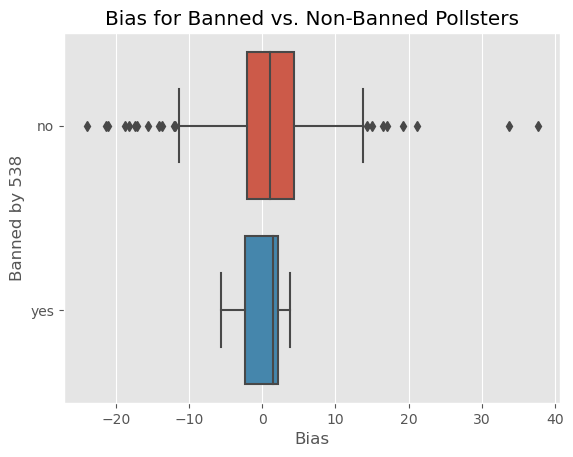

In [6]:
sns.boxplot(pollster_ratings, x = 'Bias', y = 'Banned by 538')

plt.title('Bias for Banned vs. Non-Banned Pollsters');

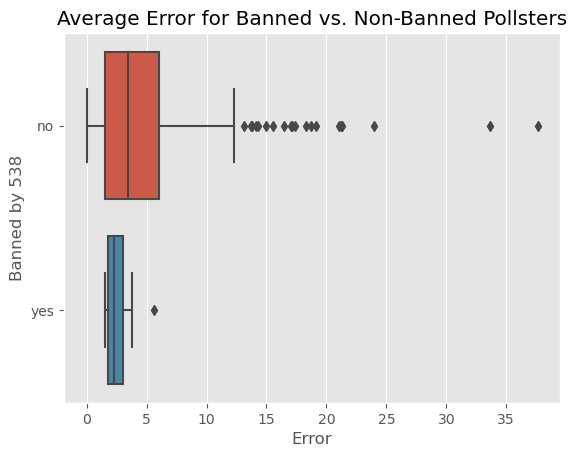

In [7]:
sns.boxplot(x = np.abs(pollster_ratings['Bias']), y = pollster_ratings['Banned by 538'])

plt.xlabel('Error')
plt.title('Average Error for Banned vs. Non-Banned Pollsters');

In [8]:
pollster_ratings['Banned by 538'].value_counts(), df['Banned by 538'].value_counts() # barely any are banned

(Banned by 538
 no     506
 yes     11
 Name: count, dtype: int64,
 Banned by 538
 no     10155
 yes      600
 Name: count, dtype: int64)

In [9]:
df.groupby('Banned by 538')['rightcall'].mean()

Banned by 538
no     0.801329
yes    0.815000
Name: rightcall, dtype: float64

538 has banned a number of pollsters from being included in their models (11 to precise). Interestingly, by measures of error, bias, and accuracy, there is no observable difference between the polls that are banned and polls that are not banned. This suggest that 538 is using other qualitative reasons to exclude these pollsters and not basing it on the quantifiable data. This, along with our lack of correlation, is starting to paint a picture that our modelling task may not lead us to much.

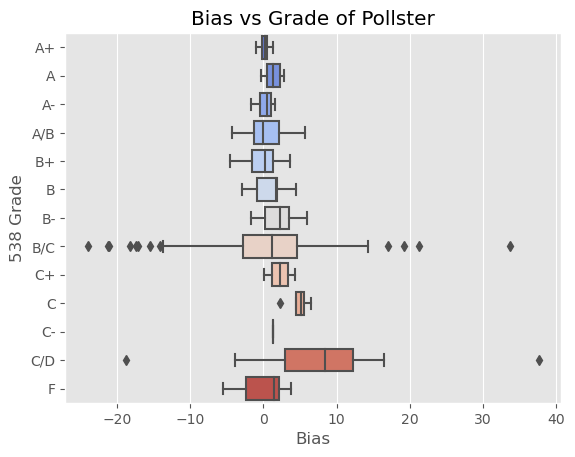

In [10]:
sns.boxplot(pollster_ratings, 
            x = 'Bias', 
            y = '538 Grade', 
            palette = 'coolwarm', 
            order = ['A+', 'A', 'A-', 'A/B', 'B+', 'B', 'B-', 'B/C', 'C+', 'C', 'C-', 'C/D', 'F'],
        )

plt.title('Bias vs Grade of Pollster');

In [11]:
pollster_ratings['538 Grade'].value_counts()[sorted(pollster_ratings['538 Grade'].unique())] 
# Vast majority of pollsters are graded B/C

538 Grade
A        8
A+       4
A-       9
A/B     47
B       10
B+      11
B-       9
B/C    382
C        4
C+       2
C-       1
C/D     19
F       11
Name: count, dtype: int64

When looking at Pollster Bias across the different grades we see that generally the higher ranked pollsters have much less variance in their bias values but overall, most of our grades do average to around 0 bias. The counts reveal that the vast majority of our pollsters are rated 'B/C' which is an average grade. We also see that there are only 11 with an 'F' grade which should be the 11 that are banned.

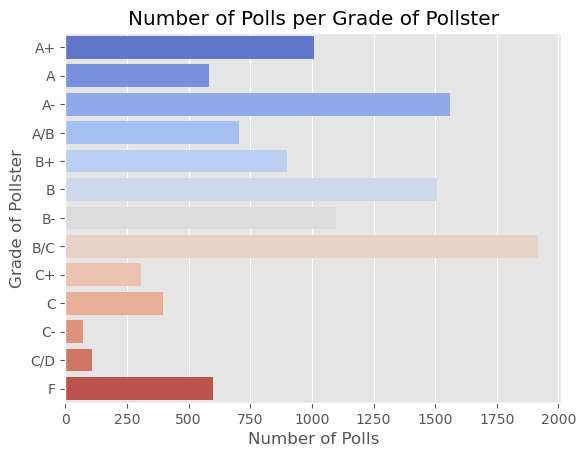

In [12]:
grade_count = df['538 Grade'].value_counts()[
    ['A+', 'A', 'A-', 'A/B', 'B+', 'B', 'B-', 'B/C', 'C+', 'C', 'C-', 'C/D', 'F']
    ]
sns.barplot(x = grade_count.values, y = grade_count.index, palette = 'coolwarm')

# Display the plot
plt.title('Number of Polls per Grade of Pollster')
plt.xlabel('Number of Polls')
plt.ylabel('Grade of Pollster');
# However the total number of polls analyzed is more even

In [13]:
df['538 Grade'].dropna().value_counts()[sorted(df['538 Grade'].dropna().unique())] 

538 Grade
A       582
A+     1007
A-     1560
A/B     703
B      1507
B+      898
B-     1097
B/C    1916
C       397
C+      307
C-       72
C/D     109
F       600
Name: count, dtype: int64

This paints a very different picture from our pollster count by grades table above. While there are fewer pollsters with high grades, those high-quality pollsters are overrepresented in terms of volume of polls. This is heartening to see, good pollsters making up a disproportionate amount of our polls means that generally the aggregates that 538 calculates for their model will be more accurate. 

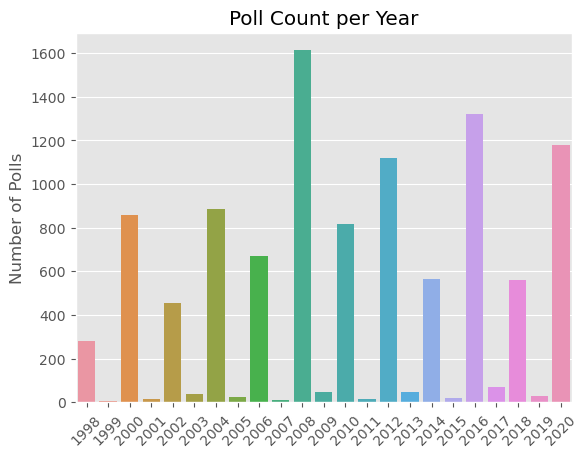

In [14]:
polls_vs_year = df.groupby('year')['Bias'].count()
sns.barplot(
    x = polls_vs_year.index,
    y = polls_vs_year.values
)
plt.xticks(rotation = 45)
plt.xlabel('')
plt.ylabel('Number of Polls')
plt.title('Poll Count per Year');

We see spikes with every election cycle as expected though interestingly we don't see polls increasing over time. While we see an initial growth from 1998 to 2008, it seems that after that period the number of polls tamps down a bit, though its still generally above the pre-2008 average for presidential elections at least. For non-presidential election years we see that the number of polls are about the same level as 2002 and 2006, though there is a relative spike in 2010. As a whole, it seems there was an explosion of polling from 1998-2008 which then regressed a bit as pollsters realized that quantity doesn't necessarily beat quality.

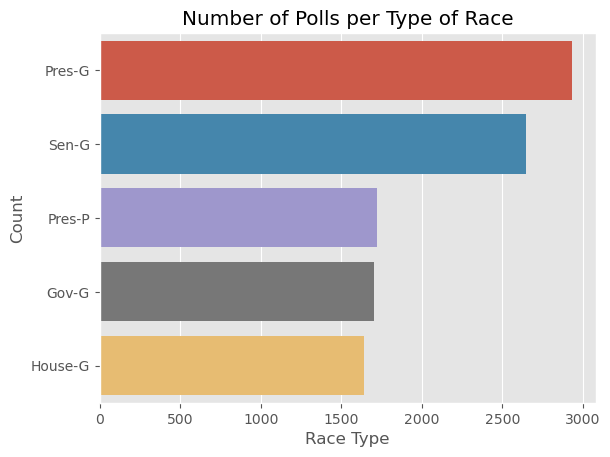

In [15]:
# Bar Chart of Number of Polls per Type of Race 
poll_count = df.groupby('type_simple')['Bias'].count().sort_values(ascending = False)

sns.barplot(x = poll_count.values, y = poll_count.index)
plt.title('Number of Polls per Type of Race')
plt.xlabel('Race Type')
plt.ylabel('Count');

#showing us that General Presidential polling has the most number of polls followed by General Senate polling. Primary, Governor, and House polling has less polls, probably because less demand/readership of these races compared to Presidential and Senate races.

In [16]:
df.groupby('type_simple')['Bias'].count()

type_simple
Gov-G      1706
House-G    1641
Pres-G     2933
Pres-P     1721
Sen-G      2647
Name: Bias, dtype: int64

We see most of our polling is done on Presidential general election (as expected, that's the one people care most about) but we also see quite a few Senate general polls. We would expect that House general would be more prolific simply due to there being over 4 times as many House seats compared to Senate seats. Its hard to make heads or tails of this but one potential explanation is that generally House races are less competitive (or at least *perceived* as less competitive) so there is less polling being done for them.

Extending this concept of how polling changed over time, let's see how poll accuracy changed over the years.

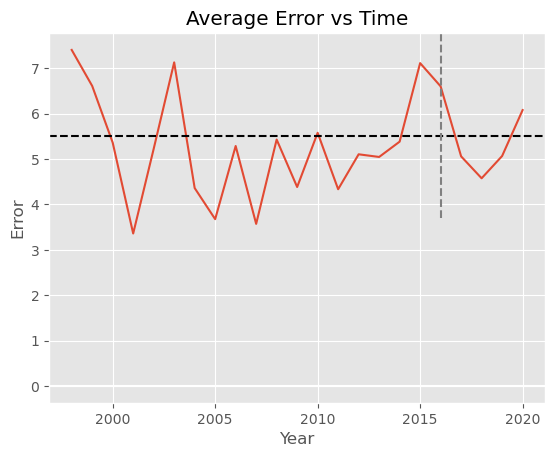

In [17]:
sns.lineplot(df.groupby('year')['error'].mean())

plt.axhline(y = np.mean(df['error']), color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'white')
plt.axvline(x = 2016, ymin = 0.5, color = 'grey', linestyle = '--')

plt.ylabel('Error')
plt.xlabel('Year')
plt.title('Average Error vs Time');

We see a fair amount of volatility in the average error for each year, we seem to be more accurate during non-presidential cycles. This makes sense, only the more politically tuned voters vote during off-years and they will generally be easier to capture in a poll about elections. Aside from that, there is no general trend across the years which is quite interesting. One note is that we had less volatility in the mid to late 2000s compared to 2014 and on. Thinking back to the number of polls across years its hard to explain why exactly this happened. Additionally, we have 2016 marked here because 2016 was a year that the polls famously failed. However we see the error was only one point higher than the average since 1998 so all things considered not particularly bad. We also see that error was a bit higher even in 2014 than it was in 2016.

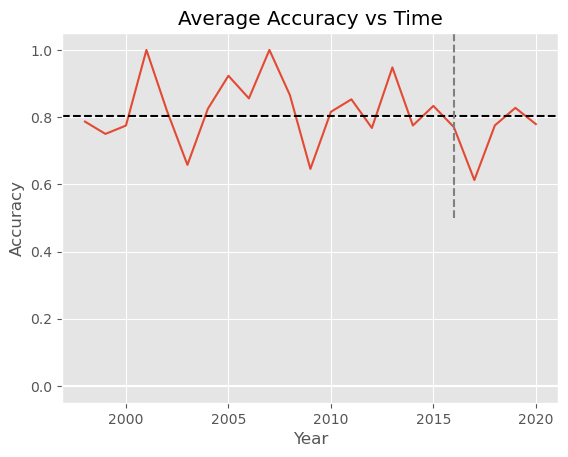

In [18]:
sns.lineplot(df.groupby('year')['rightcall'].mean())

plt.axhline(y = np.mean(df['rightcall']), color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'white')
plt.axvline(x = 2016, ymin = 0.5, color = 'grey', linestyle = '--')

plt.ylabel('Accuracy')
plt.xlabel('Year')
plt.title('Average Accuracy vs Time');

When we look at accuracy (average of rightcall) for each year we see a similar stationary trend as we saw with error but there are a few interesting differences. Firstly, while we saw less error in the 2005-2010 period we see no particular trend in accuracy which explains the generally low correlation we saw earlier. Most interestingly perhaps is that in 2016, polls were only slightly worse than average and actually in 2018 we saw our worst accuracy by quite a fair margin (especially within the post 2010 era). Our error plot showed lower error for 2018 which is quite interesting. We can suppose that most likely in 2018 the races were predicted to be close but the front-runner was predicted incorrectly a bit more frequently than other years.

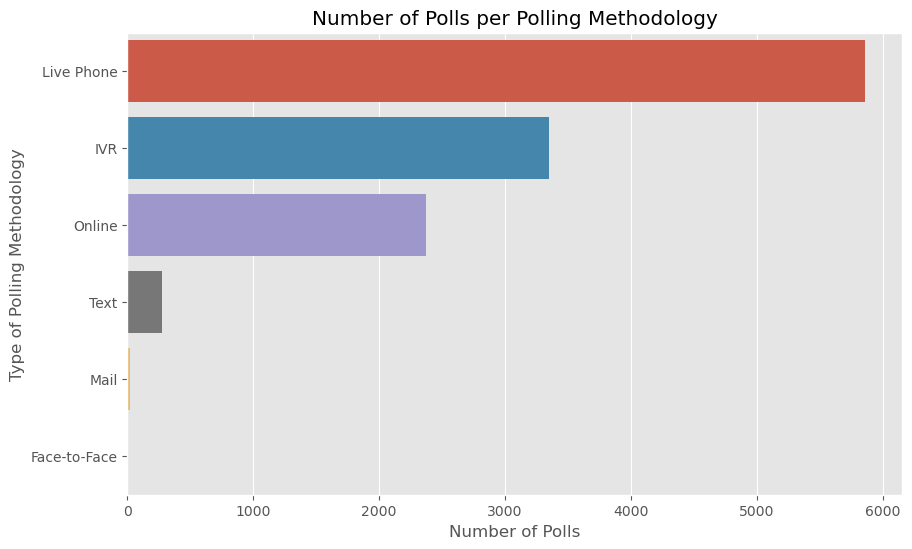

In [19]:
methods = df[['Text', 'Live Phone', 'Mail', 'Face-to-Face', 'IVR', 'Online']]

# Calculate the counts for each method
method_counts = methods.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=method_counts.values, y=method_counts.index)
# Display the plot on Number of Polls per Polling Methodology
plt.title('Number of Polls per Polling Methodology')
plt.xlabel('Number of Polls')
plt.ylabel('Type of Polling Methodology');

We see that live phone polls are the most common type of poll, with face to face polling being incredibly rare and mail polls being only slightly more common. We also see a lot of IVR and online polls. IVR is short for interactive voice recording and is the non-live version of phone polling. The methodologies can overlap however, so a poll can be both a live phone and an IVR poll (as noted in the feature extraction section). Online polling being the third most prevalent is interesting so let's take a closer look there before drawing any conclusions.

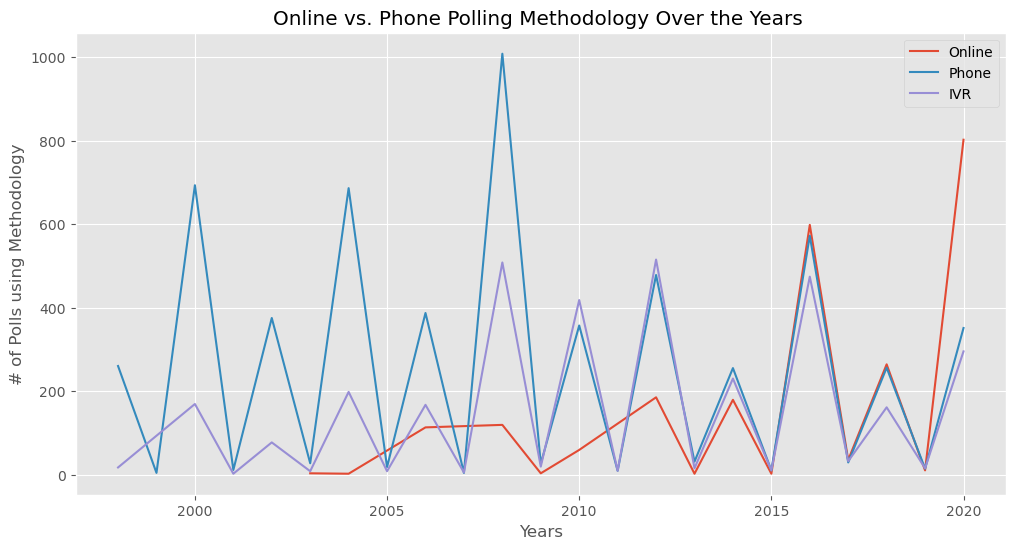

In [20]:
phone = df[df['Live Phone'] == 1].groupby('year')[['Live Phone']].count()
online = df[df['Online'] == 1].groupby('year')[['Online']].count()
ivr = df[df['IVR'] == 1].groupby('year')[['IVR']].count()

fig, ax = plt.subplots(figsize = (12, 6))
ax1 = sns.lineplot(online["Online"], ax= ax, label= "Online")
ax2 = sns.lineplot(phone["Live Phone"], ax= ax, label= "Phone")
ax3 = sns.lineplot(ivr['IVR'], ax  = ax, label = 'IVR')
ax.legend();
plt.title('Online vs. Phone Polling Methodology Over the Years ')
plt.xlabel('Years')
plt.ylabel('# of Polls using Methodology');

This trend is both expected and quite interesting, online polling was on the rise through the mid 2000s and early 2010s and actually caught up in 2016 but seems to have exploded in popularity during the 2020 election. Likewise, as online polling has increased, live phone and IVR polling has decreased, with all 3 hitting an equilibrium point in the mid 2010s. Most interestingly, we see that in 2020, online polling really took off. This is notable because the pandemic created a situation where phone-based polling should have had very high response rates as people were more likely to be at home, especially throughout the day. That we instead see the lowest phone polling volume in a decade with online polling reaching a new peak suggests that pollsters believed that online polling was the superior methodology despite what are intuitively ideal situations for phone-based polling. Our suspicion is that online polling was believed to be less likely to sample heavily towards Democrats over Republicans. COVID lockdowns during the pandemic were a hot political issue and we know that left-leaning voters were much more likely to support and follow those lockdown protocols. As a result, they were more likely to be at home and pick up a poll call. A possible explanation for this trend then becomes: pollsters realized this sampling issue and shifted to online polling under the belief that it will help mitigate this issue.

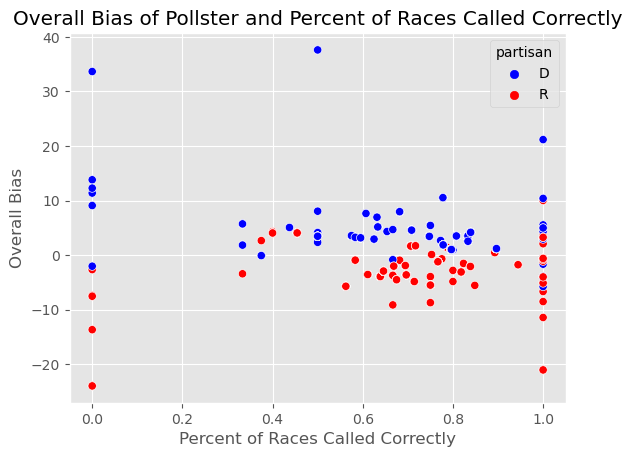

In [21]:
# Overall Bias of Pollster and Percent of Races Called Correctly
# This chart might be misleading since we are using the merged data set with the rating data 
# going to use the chart below that only looks at rating data instead but conveys the same message 
# that partisan aligned polls will lean towards their party
partisan_palette = {'D': 'blue', 'R': 'red'}
default_color = 'grey'

sns.scatterplot(
    data = df[(df['partisan'] == 'D') | (df['partisan'] == 'R')],
    x = 'Races Called Correctly',
    y = 'Bias',
    palette=partisan_palette,
    hue='partisan',
    hue_order=['D', 'R'],
    edgecolor='w',
    legend='full'
)


plt.title('Overall Bias of Pollster and Percent of Races Called Correctly')
plt.xlabel('Percent of Races Called Correctly')
plt.ylabel('Overall Bias');

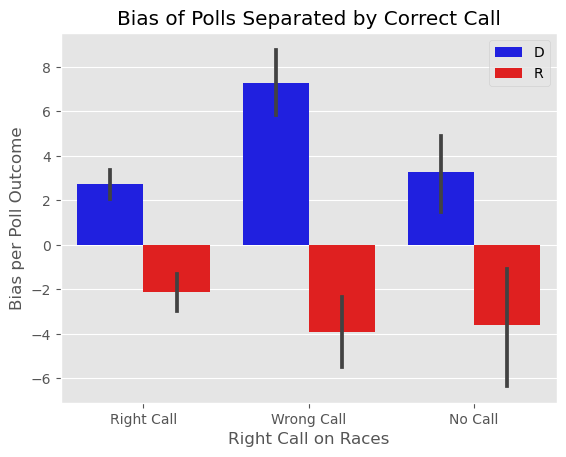

In [22]:
partisan_palette = {'D': 'blue', 'R': 'red','NPL': (0.6, 0.6, 0.6, 0.01), 'IND': (0.6, 0.6, 0.6, 0.01)}

# Create a bar plot
sns.barplot(
    x=df['rightcall'].astype(str),
    y=df['bias'],
    palette=partisan_palette,
    hue=df['partisan'],
    hue_order=['D', 'R'],
    edgecolor='none'
)

# Set the title and labels
plt.xticks(ticks = [0,1,2], labels = ['Right Call', 'Wrong Call', 'No Call'])
plt.title('Bias of Polls Separated by Correct Call')
plt.xlabel('Right Call on Races')
plt.ylabel('Bias per Poll Outcome')

# Show the legend
plt.legend(loc='upper right');

As expected, partisan polls tend to lean towards their corresponding party. We also see that the bias was higher for polls where the prediction was wrong, though we also see much higher variance in the bias for those polls. Interestingly, we see Republican polls have more variance that Democratic polls for each category. This suggests that bias may not be the right metric here because more of the Republican polls might actually be biased against the Republican party. Let's instead consider error which is $|bias|$ which will help isolate our measure of how wrong the partisan polls are across the outcome types.

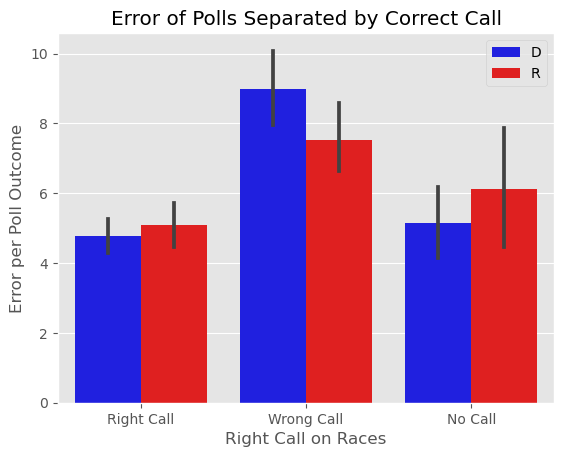

In [23]:
sns.barplot(
    x=df['rightcall'].astype(str),
    y=df['error'],
    palette=partisan_palette,
    hue=df['partisan'],
    hue_order=['D', 'R'],
    edgecolor='none'
)

# Set the title and labels
plt.xticks(ticks = [0,1,2], labels = ['Right Call', 'Wrong Call', 'No Call'])
plt.title('Error of Polls Separated by Correct Call')
plt.xlabel('Right Call on Races')
plt.ylabel('Error per Poll Outcome')

# Show the legend
plt.legend(loc='upper right');

This graph tells a slightly different story than the bias graph before. For one, while the bias graph suggested that overall Republican polls are less *biased* than Democratic polls our errors suggest that despite that, Democratic polls tend to be closer to the actual margin of the poll. Most notably we see the wrong-call mean error is much closer that the magnitude of the wrong-call mean bias from before. It seems that Democratic polls tend to systematically favor Democrats to a greater degree than Republican polls favor Republicans but despite this bias Democratic polls are slightly less *erroneous* than Republican polls.

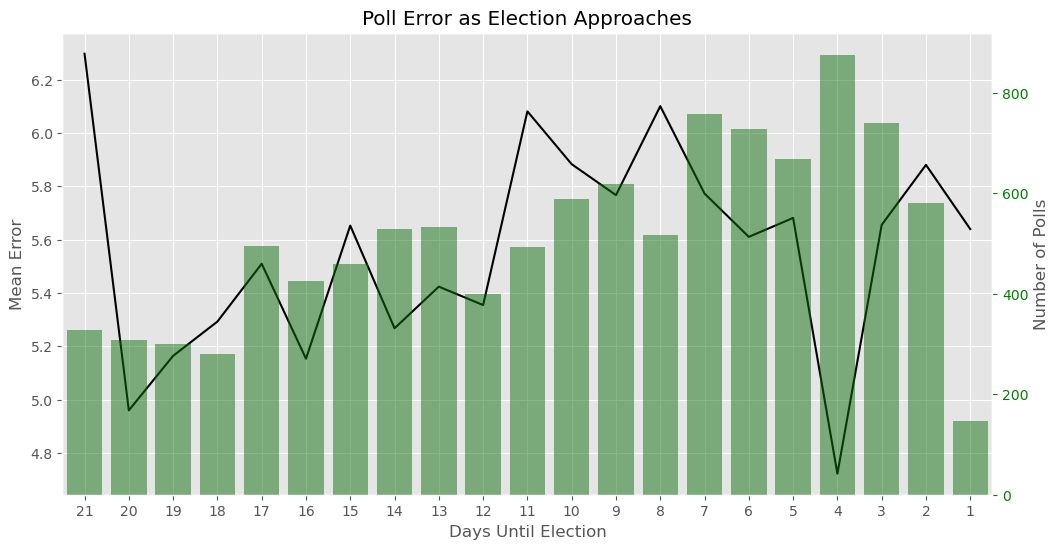

In [24]:
error_vs_days = df.groupby('days_bt_polldate_election')['error'].mean()
polls_vs_days = df.groupby('days_bt_polldate_election')['error'].count()

_, ax = plt.subplots(figsize = (12,6))
sns.lineplot(x =  error_vs_days.index - 1, y = error_vs_days.values, ax = ax, color = 'black')

ax2 = ax.twinx()
sns.barplot(x = -1 * polls_vs_days.index, y = polls_vs_days.values, color = 'green', ax  = ax2, alpha = 0.5)
ax2.grid(False)
ax2.set_xticks(ticks = ax.get_xticks(), labels = range(21, 0, -1))

plt.title('Poll Error as Election Approaches')
ax.set_xlabel('Days Until Election')
ax.set_ylabel('Mean Error')
ax2.set_ylabel('Number of Polls')

ax2.tick_params(colors = 'green', which = 'major');

How poll error changes as the election approaches is not immediately apparent from this plot alone. We see that generally there are more polls as the election approaches along with an expected decrease in the last few days where they become less valuable because there isn't enough time to take action on them. However, we see a number of seemingly arbitrary spikes and drops in poll error. We see the lowest poll errors at 20 days and 4 days prior however our highest is 21 days prior and days 5 and 3 prior both have equally high errors that are much higher than the error on 4 days prior. Let's look at this plot more granularly and see if that helps make trends more apparent.

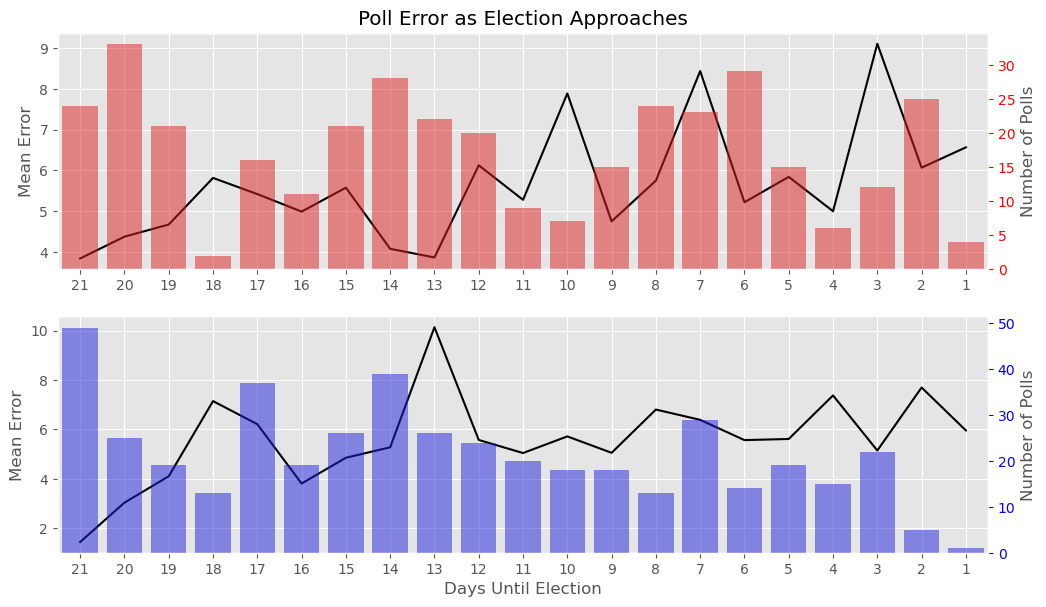

In [25]:
reps_e_by_days = df[df['partisan'] == 'R'].groupby(
    'days_bt_polldate_election'
    )['error'].mean()
reps_p_by_days = df[df['partisan'] == 'R'].groupby(
    'days_bt_polldate_election'
    )['error'].count()

dems_e_by_days = df[df['partisan'] == 'D'].groupby(
    'days_bt_polldate_election'
    )['error'].mean()
dems_p_by_days = df[df['partisan'] == 'D'].groupby(
    'days_bt_polldate_election'
    )['error'].count()


_, ax = plt.subplots(nrows = 2, figsize = (12,9*.75))

sns.lineplot(x =  reps_e_by_days.index - 1, y = reps_e_by_days.values, ax = ax[0], color = 'black')

ax02 = ax[0].twinx()
sns.barplot(x = -1 * reps_p_by_days.index, y = reps_p_by_days.values, color = 'red', ax  = ax02, alpha = 0.5)
ax02.grid(False)
ax02.set_xticks(ticks = ax[0].get_xticks(), labels = range(21, 0, -1))

plt.title('Poll Error as Election Approaches')
ax[0].set_xlabel('')
ax[0].set_ylabel('Mean Error')
ax02.set_ylabel('Number of Polls')

ax02.tick_params(colors = 'red', which = 'major')

sns.lineplot(x =  dems_e_by_days.index - 1, y = dems_e_by_days.values, ax = ax[1], color = 'black')

ax12 = ax[1].twinx()
sns.barplot(x = -1 * dems_p_by_days.index, y = dems_p_by_days.values, color = 'blue', ax  = ax12, alpha = 0.5)
ax12.grid(False)
ax12.set_xticks(ticks = ax[1].get_xticks(), labels = range(21, 0, -1))

ax[1].set_xlabel('Days Until Election')
ax[1].set_ylabel('Mean Error')
ax12.set_ylabel('Number of Polls')

ax12.tick_params(colors = 'blue', which = 'major');

When we look only at the Democratic and Republican partisan poll we can see some interesting trends. Unlike the overall trend, partisan polls were least erroneous at 21 days out and tended to become less accurate as the election approaches. This trend is mostly poll-count agnostic but there is a bit of evidence that more polls on that day tends to a slight decrease in error for Democratic polls at least. We see less of this trend in Republican polls but we do see it a bit at 8-6 days prior and 2 days prior compared to 3 days prior. This could be suggesting that partisan polling is more likely to bias itself towards the party as the election gets closer but that's a very strong conclusion to make so we would want much more evidence before making that claim. It would be interesting to see polls from even further out but for now let's just look at our NPL polls instead.

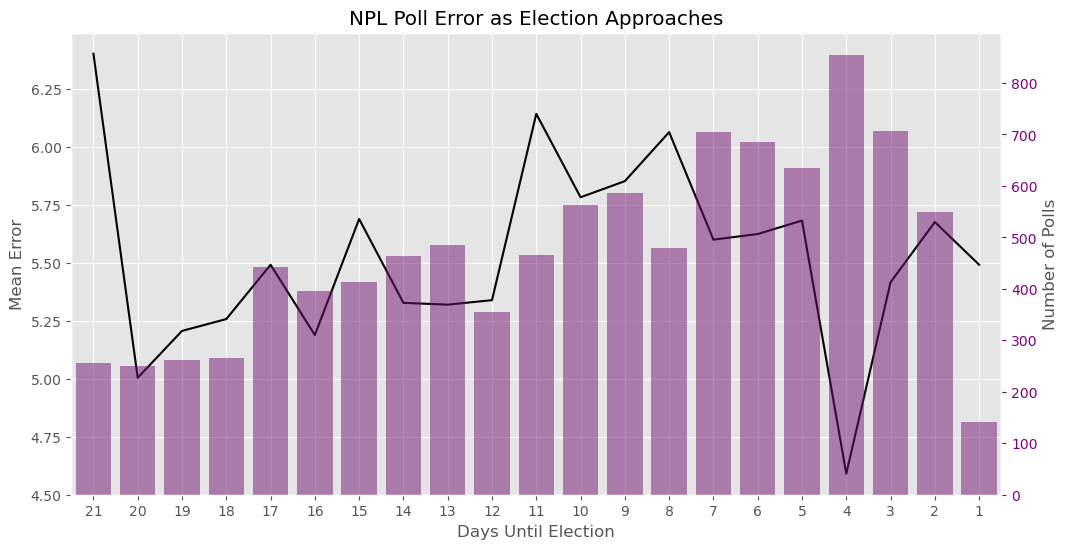

In [26]:
error_vs_days = df[df['partisan'] == 'NPL'].groupby('days_bt_polldate_election')['error'].mean()
polls_vs_days = df[df['partisan'] == 'NPL'].groupby('days_bt_polldate_election')['error'].count()

_, ax = plt.subplots(figsize = (12,6))
sns.lineplot(x =  error_vs_days.index - 1, y = error_vs_days.values, ax = ax, color = 'black')

ax2 = ax.twinx()
sns.barplot(x = -1 * polls_vs_days.index, y = polls_vs_days.values, color = 'purple', ax  = ax2, alpha = 0.5)
ax2.grid(False)
ax2.set_xticks(ticks = ax.get_xticks(), labels = range(21, 0, -1))

plt.title('NPL Poll Error as Election Approaches')
ax.set_xlabel('Days Until Election')
ax.set_ylabel('Mean Error')
ax2.set_ylabel('Number of Polls')

ax2.tick_params(colors = 'purple', which = 'major');

When looking at non-Democratic or Republican polls, we see a similar overall trend to the original non-party respective plot (due to the vast majority of polls being NPL). Most notably here, we see a huge spike in error at 21 days prior but otherwise the error is more or less constant. There is a sharp dip at 20 days prior but from there through 1 day prior (4 days prior notwithstanding) we see only a slight increase in error. 4 days prior again shows us the lowest error by far and even has the most polls by a fair margin. Overall, this trend continues to be near-inscrutable which, again, suggests we will not have much success in our modelling attempts.

As we head into modelling, it has become somewhat clear that our measures on polls do not have a strong relationship with how accurate or biased that poll is. We can reasonably expect that our modelling will have issues passing our baseline values and we should be very careful to not put too much stock into any trends we see from clustering. While this is unfortunate for the purposes of our goals this is actually a good thing we believe. This would suggest that polls are not systematically wrong or inaccurate and therefore are as accurate as feasible given the difficulty of measuring who will win an election. 